In [14]:
install.packages("bnstruct")

Installing package into ‘/home/kabo/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’




In [15]:
library("dplyr")
library("igraph")

library("bnstruct")

Loading required package: bitops



## Inputs: 

1. Set of nodes *Z*
2. Ordering of the nodes
3. Upper bound on the number of parents (for each node) *u*
4. Database *D* of m cases

In [16]:
plot_BN <- function(papitos){
    
    #Create an "edge list matrix" ---> https://igraph.org/r/doc/graph_from_edgelist.html
    
    outgoing <- c()
    incoming <- c()
    for(i in 1:length(papitos)){
        for(j in papitos[[i]]){
            outgoing <- c(outgoing, as.character(j))
            incoming <- c(incoming, as.character(i))
            
        }
    }
    edge_list_matrix <- t(rbind(outgoing, incoming)) #transpose
    print(edge_list_matrix)
    
    
    network <- graph_from_edgelist(edge_list_matrix, directed=TRUE)
    par(bg="beige")
    igraph::plot.igraph(network, 
                                layout=layout.fruchterman.reingold,
                                vertex.color = rgb(0.7,0.1,0.9),
                                vertex.label.font=5,
                                vertex.label.cex = 1.9,
                                vertex.frame.color = "white",                 
                                vertex.shape="square",                        
                                vertex.size=25,                               
                                vertex.label.color="white", 
                                edge.width=3,
                                edge.color='black',
                                edge.arrow.size=1,
                                edge.arrow.width=1,
                                edge.curved=0.25)
        title("Learned Bayesian Network", cex.main=2,col.main="black")
}

In [17]:
N_tensor <- function(D, i, V.i, pi.i){
    result <- D %>% count(D[,pi.i], name='j_counts')
    if (length(pi.i) == 1){colnames(result)[1] <- 'j'}
        for (k in V.i){
            k_count <- D[D[, i]==k,] %>% count(D[D[, i]==k,pi.i])
            if (length(pi.i) == 1){colnames(k_count)[1] <- 'j'}
            colnames(k_count)[length(colnames(k_count))]<- k
            result <- merge(result, k_count, all.x=TRUE) 
        }
        result[is.na(result)] <- 0
    #names(result)[1] <- 'j_counts'
    #names(result)[2:(length(V.i)+1)] <- V.i
    cat('\n')
    print(result)
    return(result)
}

g <- function(V.i, r.i, N.tensor){
    N.ij <- N.tensor$j_counts
    q.i <- length(N.ij) # number of unique combinations of the parents realizations
    result <- 1
    for (j in 1:q.i) {
        a <- 1
        for (k in V.i){a <- a*factorial(N.tensor[j,as.character(k)])}
        result <- result*a*factorial(r.i-1)/factorial(N.ij[j]+r.i-1)
    }
    return(result)
}


k2 <- function(Z, u, D){
    V <- unname(sapply(D, unique)) #it's a matrix
    r <- unname(sapply(D, n_distinct)) #it's a vector
    parents <- list()
    for (i in 1:length(Z)){
        cat('\n iteration', i)
        pi.i <- NULL 
        Nijk <- N_tensor(D, Z[i], V[,i], pi.i)
        P_old <- g(V[,i],r[i], Nijk)
        proceed <- TRUE
        changed = FALSE
        while (proceed & (length(pi.i)<u & i>1)){
            pred.i <- setdiff(Z[1:i-1], pi.i)
            P <- 0
            for (node in pred.i){
                new_set <- union(pi.i, node)
                Nijk <- N_tensor(D, Z[i], V[,i], new_set)
                P <- g(V[,i], r[i], Nijk)
                if (P > P_old){
                    P_old <- P
                    temp.pi <- new_set
                    changed = TRUE
                }
            }
            if (changed != TRUE){
                proceed = FALSE
            } else{
                pi.i <- temp.pi
                changed = FALSE
            }
        }
        cat('\n P:', P_old)
        parents <- append(parents, list(pi.i))
    } 
    return(parents)
}


In [18]:
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3<- c(0,1,1,1,0,1,1,0,1,0)

D <- data.frame(x1, x2, x3)

print(D)


   x1 x2 x3
1   1  0  0
2   1  1  1
3   0  0  1
4   1  1  1
5   0  0  0
6   0  1  1
7   1  1  1
8   0  0  0
9   1  1  1
10  0  0  0


In [19]:
papitos <- k2(c(1,2,3), u=3, D)


 iteration 1
  j_counts 1 0
1       10 5 5

 P: 0.0003607504
 iteration 2
  j_counts 0 1
1       10 5 5

  j j_counts 0 1
1 0        5 4 1
2 1        5 1 4

 P: 0.001111111
 iteration 3
  j_counts 0 1
1       10 4 6

  j j_counts 0 1
1 0        5 3 2
2 1        5 1 4

  j j_counts 0 1
1 0        5 4 1
2 1        5 0 5

  x2 x1 j_counts 0 1
1  0  0        4 3 1
2  0  1        1 1 0
3  1  0        1 0 1
4  1  1        4 0 4

 P: 0.005555556

In [20]:
papitos

[[1]]
NULL

[[2]]
[1] 1

[[3]]
[1] 2

In [21]:
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3<- c(0,0,1,0,0,0,0,0,0,0)
x4<- c(1,0,1,0,1,0,0,0,0,1)
x5<- c(1,1,1,0,1,0,1,0,1,1)
x6<- c(1,0,0,0,0,0,1,0,0,1)
x7<- c(1,0,1,1,1,1,0,0,1,0)
x8<- c(1,0,1,0,1,1,1,1,1,1)
x9<- c(1,0,0,1,1,1,1,1,0,1)
x10<- c(1,1,1,1,1,0,0,0,0,1)

In [22]:
D <- data.frame(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)

papitos <- k2(c(1:10), u=10, D)


 iteration 1
  j_counts 1 0
1       10 5 5

 P: 0.0003607504
 iteration 2
  j_counts 0 1
1       10 5 5

  j j_counts 0 1
1 0        5 4 1
2 1        5 1 4

 P: 0.001111111
 iteration 3
  j_counts 0 1
1       10 9 1

  j j_counts 0 1
1 0        5 4 1
2 1        5 5 0

  j j_counts 0 1
1 0        5 4 1
2 1        5 5 0

 P: 0.009090909
 iteration 4
  j_counts 1 0
1       10 4 6

  j j_counts 1 0
1 0        5 3 2
2 1        5 1 4

  j j_counts 1 0
1 0        5 4 1
2 1        5 0 5

  j j_counts 1 0
1 0        9 3 6
2 1        1 1 0

  x2 x1 j_counts 1 0
1  0  0        4 3 1
2  0  1        1 1 0
3  1  0        1 0 1
4  1  1        4 0 4

  x2 x3 j_counts 1 0
1  0  0        4 3 1
2  0  1        1 1 0
3  1  0        5 0 5

 P: 0.005555556
 iteration 5
  j_counts 1 0
1       10 7 3

  j j_counts 1 0
1 0        5 3 2
2 1        5 4 1

  j j_counts 1 0
1 0        5 4 1
2 1        5 3 2

  j j_counts 1 0
1 0        9 6 3
2 1        1 1 0

  j j_counts 1 0
1 0        6 3 3
2 1        4 4 0

  x

In [23]:
papitos

[[1]]
NULL

[[2]]
[1] 1

[[3]]
NULL

[[4]]
[1] 2

[[5]]
[1] 4 1

[[6]]
[1] 5

[[7]]
[1] 6

[[8]]
[1] 1

[[9]]
[1] 3 1 6 5

[[10]]
[1] 4 8

      outgoing incoming
 [1,] "1"      "2"     
 [2,] "2"      "4"     
 [3,] "4"      "5"     
 [4,] "1"      "5"     
 [5,] "5"      "6"     
 [6,] "6"      "7"     
 [7,] "1"      "8"     
 [8,] "3"      "9"     
 [9,] "1"      "9"     
[10,] "6"      "9"     
[11,] "5"      "9"     
[12,] "4"      "10"    
[13,] "8"      "10"    


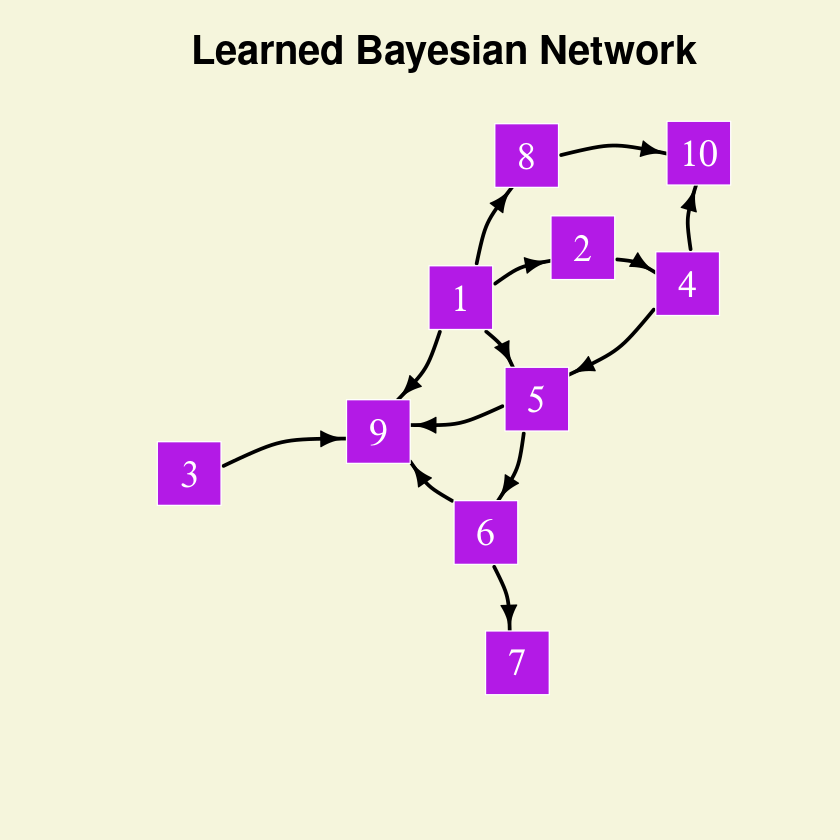

In [24]:
plot_BN(papitos)

In [27]:
k2_bnstruct <- function(D, u, bootstrap = FALSE){
    net <- learn.network(D, bootstrap)
    return (net)
}



function(D, bootstrap = FALSE){
    net <- learn.network(D, bootstrap)
    return (net)
}